# CellDART Example Code: mouse brain 
## (10x Visium of anterior mouse brain + scRNA-seq data of mouse brain)

In [1]:
import glob
import os
import pickle
from math import ceil

import anndata as ad
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scanpy as sc
import seaborn as sns
import scipy.stats as ss

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from CellDART import da_cellfraction
from CellDART.utils import random_mix

from tqdm.autonotebook import tqdm


/tmp/ipykernel_1146/2591166922.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import tensorflow as tf   # TensorFlow registers PluggableDevices here.
tf.config.list_physical_devices() 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
NUM_MARKERS = 20
N_MIX = 8
N_SPOTS = 20000
TRAIN_USING_ALL_ST_SAMPLES = False


SAMPLE_ID_N = "151673"
INITIAL_TRAIN_EPOCHS = 100


BATCH_SIZE = 512
ALPHA = 1 / 0.6
ALPHA_LR = 5
N_ITER = 3000

# SPATIALLIBD_DIR = "../AGrEDA/data/spatialLIBD"
# SC_DLPFC_PATH = "../AGrEDA/data/sc_dlpfc/adata_sc_dlpfc.h5ad"
PROCESSED_DATA_DIR = "../AGrEDA/data/preprocessed"

BOOTSTRAP = True
BOOTSTRAP_ROUNDS = 10
BOOTSTRAP_ALPHAS = [0.6, 1/0.6]

MODEL_NAME = 'CellDART'

In [4]:
results_folder = os.path.join("results", MODEL_NAME, "TESTING")

In [5]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3


-----
anndata     0.8.0
scanpy      1.9.1
-----
CellDART                                    NA
PIL                                         9.3.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
asttokens                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
certifi                                     2022.09.24
cffi                                        1.15.1
charset_normalizer                          2.1.1
cycler                                      0.10.0
cython_runtime                              NA
dateutil                                    2.8.2
debugpy                                     1.6.3
decorator                                   5.1.1
defusedxml                                  0.7.1
entrypoints                                 0.4
executing                                   1.2.0
flatbuffers                                 NA
gast           

## 1. Data load
### load scanpy data - 10x datasets

In [6]:
# SPATIALLIBD_DIR = "../AGrEDA/data/spatialLIBD"
# SC_DLPFC_PATH = "../AGrEDA/data/sc_dlpfc/adata_sc_dlpfc.h5ad"

# sc.logging.print_versions()
# sc.set_figure_params(facecolor="white", figsize=(8, 8))
# sc.settings.verbosity = 3

# adata_dir = os.path.join(SPATIALLIBD_DIR, "adata")

# adata_spatialLIBD_d = {}

# for name in glob.glob(os.path.join(adata_dir, "adata_spatialLIBD-*.h5ad")):
#     sample_id = name.partition("-")[2].rpartition(".")[0]
#     # print(sample_id)
#     adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)


In [7]:
# adata_sc_dlpfc = sc.read_h5ad(SC_DLPFC_PATH)
# sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e4)
# adata_sc_dlpfc.var_names_make_unique()


In [8]:
# #Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])


In [9]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')


In [10]:
# df_genelists = pd.read_pickle("../AGrEDA/data/sc_dlpfc/df_genelists.pkl")
# res_genes = []
# for column in df_genelists.head(NUM_MARKERS):
#     res_genes.extend(df_genelists.head(NUM_MARKERS)[column].tolist())
# res_genes_ = list(set(res_genes))


### Select same gene features 

In [11]:
# adata_spatialLIBD = ad.concat(
#     adata_spatialLIBD_d.values(), label="sample_id", keys=adata_spatialLIBD_d.keys()
# )
# adata_spatialLIBD.obs_names_make_unique()
# sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e4)
# st_sample_id_l = adata_spatialLIBD.obs["sample_id"].unique()


In [12]:
# adata_spatialLIBD.var_names_make_unique()
# inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
# print("Selected Feature Gene number", len(inter_genes))
# adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

# adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


## Format Data

### Array of single cell & spatial data
- Single cell data with labels
- Spatial data without labels


### Generate Pseudospots

In [13]:
# def log_minmaxscale(arr):
#     """returns log1pc and min/max normalized arr"""
#     arrd = len(arr)
#     arr = np.log1p(arr)

#     arr_minus_min = arr - np.reshape(np.min(arr, axis=1), (arrd, 1))
#     min2max = np.reshape((np.max(arr, axis=1) - np.min(arr, axis=1)), (arrd, 1))
#     return arr_minus_min / min2max


In [14]:
# df_sc = adata_sc_dlpfc.to_df()
# df_sc.index = pd.MultiIndex.from_frame(adata_sc_dlpfc.obs.reset_index())

# sc_sub_dict = dict(zip(range(df_genelists.shape[1]), df_genelists.columns.tolist()))
# sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())


In [15]:
# lab_sc_sub = df_sc.index.get_level_values("cell_subclass")
# lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
# lab_sc_num = np.asarray(lab_sc_num, dtype="int")

# mat_sc_train, mat_sc_eval, lab_sc_num_train, lab_sc_num_eval = train_test_split(
#     df_sc.to_numpy(),
#     lab_sc_num,
#     test_size=0.2,
#     random_state=225,
#     stratify=lab_sc_num,
# )
# mat_sc_val, mat_sc_test, lab_sc_num_val, lab_sc_num_test = train_test_split(
#     mat_sc_eval,
#     lab_sc_num_eval,
#     test_size=0.5,
#     random_state=263,
#     stratify=lab_sc_num_eval,
# )

# sc_mix_train, lab_mix_train = random_mix(
#     mat_sc_train, lab_sc_num_train, nmix=N_MIX, n_samples=N_SPOTS
# )
# sc_mix_val, lab_mix_val = random_mix(
#     mat_sc_val, lab_sc_num_val, nmix=N_MIX, n_samples=N_SPOTS // 8
# )
# sc_mix_test, lab_mix_test = random_mix(
#     mat_sc_test, lab_sc_num_test, nmix=N_MIX, n_samples=N_SPOTS // 8
# )


# sc_mix_train_s = log_minmaxscale(sc_mix_train)
# sc_mix_val_s = log_minmaxscale(sc_mix_val)
# sc_mix_test_s = log_minmaxscale(sc_mix_test)


### Format Spatial Data

In [16]:
# mat_sp_test_d = {}
# mat_sp_test_s_d = {}
# for sample_id in st_sample_id_l:
#     mat_sp_test_d[sample_id] = adata_spatialLIBD[
#         adata_spatialLIBD.obs.sample_id == sample_id
#     ].X.todense()

#     mat_sp_test_s_d[sample_id] = log_minmaxscale(mat_sp_test_d[sample_id])

# if TRAIN_USING_ALL_ST_SAMPLES:
#     mat_sp_train = adata_spatialLIBD.X.todense()
#     mat_sp_train_s = log_minmaxscale(mat_sp_train)
# else:
#     mat_sp_train_d = mat_sp_test_d
#     mat_sp_train_s_d = mat_sp_test_s_d


In [17]:
# Load spatial data
mat_sp_test_s_d = {}
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_test_s_d.hdf5"), "r") as f:
    for sample_id in f:
        mat_sp_test_s_d[sample_id] = f[sample_id][()]

if TRAIN_USING_ALL_ST_SAMPLES:
    with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s.hdf5"), "r") as f:
        mat_sp_train_s = f["all"][()]
else:
    mat_sp_train_s_d = mat_sp_test_s_d

# Load sc data
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "sc.hdf5"), "r") as f:
    sc_mix_train_s = f["X/train"][()]
    sc_mix_val_s = f["X/val"][()]
    sc_mix_test_s = f["X/test"][()]

    lab_mix_train = f["y/train"][()]
    lab_mix_val = f["y/val"][()]
    lab_mix_test = f["y/test"][()]

# Load helper dicts / lists
with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict.pkl"), "rb") as f:
    sc_sub_dict = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict2.pkl"), "rb") as f:
    sc_sub_dict2 = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "st_sample_id_l.pkl"), "rb") as f:
    st_sample_id_l = pickle.load(f)


In [18]:
adata_spatialLIBD = sc.read_h5ad(
    os.path.join(PROCESSED_DATA_DIR, "adata_spatialLIBD.h5ad")
)

adata_spatialLIBD_d = {}
for sample_id in st_sample_id_l:
    adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ]
    adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
        adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
    )

In [19]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if "Ex" in v:
        num_name_exN_l.append((k, v, int(v.split("_")[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l

Ex_to_L_d = {
    1: {5, 6},
    2: {5},
    3: {4, 5},
    4: {6},
    5: {5},
    6: {4, 5, 6},
    7: {4, 5, 6},
    8: {5, 6},
    9: {5, 6},
    10: {2, 3, 4},
}

numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


## 3. Training: Adversarial domain adaptation for cell fraction estimation
### Parameters
- alpha: loss weights for adversarial learning for pooling domain classifier
- alpha_lr: learning rate for training domain classifier  (alpha_lr *0.001)
- emb_dim: embedding dimension (feature dimension)
- batch_size : batch size for the training
- n_iterations: iteration number of adversarial training
- initial_train: if true, classifier model is trained firstly before adversarial domain adaptation
- initial_train_epochs: number of epochs for inital training



In [20]:
st_sample_id_l = [SAMPLE_ID_N]


In [21]:
def gen_pred_true(visnum, adata, pred_sp):
    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)

    return y_pred, y_true

def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    y_pred, y_true = gen_pred_true(visnum, adata, pred_sp)

    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)

    return metrics.roc_auc_score(y_true, y_pred)

In [22]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    embs, clssmodel, clssmodel_noda = da_cellfraction.train(
        sc_mix_train_s,
        lab_mix_train,
        mat_sp_train_s,
        alpha=ALPHA,
        alpha_lr=5,
        emb_dim=64,
        batch_size=BATCH_SIZE,
        n_iterations=N_ITER,
        initial_train=True,
        initial_train_epochs=INITIAL_TRAIN_EPOCHS,
    )
elif BOOTSTRAP:
    pred_sp_boostrap_d = {}
    
    outer = tqdm(total=len(BOOTSTRAP_ALPHAS), desc="Alphas", position=0)
    inner1 = tqdm(total=len(st_sample_id_l), desc=f"Sample", position=1)
    inner2 = tqdm(total=BOOTSTRAP_ROUNDS, desc=f"Bootstrap #", position=2)
    for alpha in BOOTSTRAP_ALPHAS:
        
        inner1.refresh()  # force print final state
        inner1.reset()  # reuse bar

        
        pred_sp_boostrap_d[alpha] = {}
        

        for sample_id in st_sample_id_l:
            inner2.refresh()  # force print final state
            inner2.reset()  # reuse bar
            
            pred_sp_boostrap_d[alpha][sample_id] = []
            for i in range(BOOTSTRAP_ROUNDS):
                print(f"Adversarial training for ST slide {sample_id}: ")
                embs, clssmodel, _ = da_cellfraction.train(
                    sc_mix_train_s,
                    lab_mix_train,
                    mat_sp_train_s_d[sample_id],
                    alpha=alpha,
                    alpha_lr=5,
                    emb_dim=64,
                    batch_size=BATCH_SIZE,
                    n_iterations=N_ITER,
                    initial_train=True,
                    initial_train_epochs=10,
                    seed = i,
                )

                pred_sp_boostrap_d[alpha][sample_id].append(clssmodel.predict(
                    mat_sp_test_s_d[sample_id]
                ))
                inner2.update(1)
            inner1.update(1)
        outer.update(1)

else:
    embs_d, clssmodel_d, clssmodel_noda_d = {}, {}, {}
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")
        embs, clssmodel, clssmodel_noda = da_cellfraction.train(
            sc_mix_train_s,
            lab_mix_train,
            mat_sp_train_s_d[sample_id],
            alpha=ALPHA,
            alpha_lr=5,
            emb_dim=64,
            batch_size=BATCH_SIZE,
            n_iterations=N_ITER,
            initial_train=True,
            initial_train_epochs=100,
        )
        embs_d[sample_id] = embs
        clssmodel_d[sample_id] = clssmodel
        clssmodel_noda_d[sample_id] = clssmodel_noda


Alphas:   0%|          | 0/2 [00:00<?, ?it/s]

Sample:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap #:   0%|          | 0/10 [00:00<?, ?it/s]

Adversarial training for ST slide 151673: 
Train on 20000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 38us/sample - loss: 1.2451 - mae: 0.0350
Epoch 2/10
20000/20000 [==============================] - 0s 11us/sample - loss: 0.8847 - mae: 0.0290
Epoch 3/10
20000/20000 [==============================] - 0s 10us/sample - loss: 0.7157 - mae: 0.0258
Epoch 4/10
20000/20000 [==============================] - 0s 11us/sample - loss: 0.6230 - mae: 0.0236
Epoch 5/10
20000/20000 [==============================] - 0s 10us/sample - loss: 0.5808 - mae: 0.0223
Epoch 6/10
20000/20000 [==============================] - 0s 11us/sample - loss: 0.5612 - mae: 0.0217
Epoch 7/10
20000/20000 [==============================] - 0s 9us/sample - loss: 0.5399 - mae: 0.0211
Epoch 8/10
20000/20000 [==============================] - 0s 10us/sample - loss: 0.5258 - mae: 0.0207
Epoch 9/10
20000/20000 [==============================] - 0s 11us/sample - loss: 0.5117 - mae: 0.0204
Epoch 10/10
20000

/home/wma/miniconda3/envs/CellDART/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Iteration 99, source loss =  2.317, discriminator acc = 0.871
Iteration 199, source loss =  1.722, discriminator acc = 0.974
Iteration 299, source loss =  1.697, discriminator acc = 0.154
Iteration 399, source loss =  1.516, discriminator acc = 0.887
Iteration 499, source loss =  1.195, discriminator acc = 0.154
Iteration 599, source loss =  1.245, discriminator acc = 0.932
Iteration 699, source loss =  1.159, discriminator acc = 0.237
Iteration 799, source loss =  1.148, discriminator acc = 0.164
Iteration 899, source loss =  1.132, discriminator acc = 0.999
Iteration 999, source loss =  1.208, discriminator acc = 0.154
Iteration 1099, source loss =  1.017, discriminator acc = 1.000
Iteration 1199, source loss =  1.079, discriminator acc = 0.871
Iteration 1299, source loss =  0.944, discriminator acc = 0.999
Iteration 1399, source loss =  0.922, discriminator acc = 0.091
Iteration 1499, source loss =  0.878, discriminator acc = 0.861
Iteration 1599, source loss =  0.845, discriminator

/home/wma/miniconda3/envs/CellDART/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Adversarial training for ST slide 151673: 
Train on 20000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 26us/sample - loss: 1.2092 - mae: 0.0344
Epoch 2/10
20000/20000 [==============================] - 0s 10us/sample - loss: 0.8525 - mae: 0.0285
Epoch 3/10
20000/20000 [==============================] - 0s 11us/sample - loss: 0.6922 - mae: 0.0253
Epoch 4/10
20000/20000 [==============================] - 0s 10us/sample - loss: 0.6121 - mae: 0.0232
Epoch 5/10
20000/20000 [==============================] - 0s 10us/sample - loss: 0.5778 - mae: 0.0221
Epoch 6/10
20000/20000 [==============================] - 0s 10us/sample - loss: 0.5558 - mae: 0.0215
Epoch 7/10
20000/20000 [==============================] - 0s 11us/sample - loss: 0.5377 - mae: 0.0210
Epoch 8/10
20000/20000 [==============================] - 0s 10us/sample - loss: 0.5224 - mae: 0.0206
Epoch 9/10
20000/20000 [==============================] - 0s 11us/sample - loss: 0.5114 - mae: 0.0203
Epoch 10/10
2000

Iteration 1799, source loss =  0.716, discriminator acc = 0.636
Iteration 1899, source loss =  0.717, discriminator acc = 0.842
Iteration 1999, source loss =  0.681, discriminator acc = 0.818
Iteration 2099, source loss =  0.666, discriminator acc = 0.793
Iteration 2199, source loss =  0.686, discriminator acc = 0.937
Iteration 2299, source loss =  0.982, discriminator acc = 0.024
Iteration 2399, source loss =  0.851, discriminator acc = 0.022
Iteration 2499, source loss =  1.258, discriminator acc = 0.023
Iteration 2599, source loss =  0.795, discriminator acc = 0.387
Iteration 2699, source loss =  0.657, discriminator acc = 0.284
Iteration 2799, source loss =  0.681, discriminator acc = 0.731
Iteration 2899, source loss =  0.696, discriminator acc = 0.423
Iteration 2999, source loss =  0.743, discriminator acc = 0.342
Adversarial training for ST slide 151673: 
Train on 20000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 29us/sample - loss: 1.2380 - mae: 0.0347


Iteration 499, source loss =  1.353, discriminator acc = 0.154
Iteration 599, source loss =  1.149, discriminator acc = 0.411
Iteration 699, source loss =  1.443, discriminator acc = 0.218
Iteration 799, source loss =  1.468, discriminator acc = 0.154
Iteration 899, source loss =  1.196, discriminator acc = 0.557
Iteration 999, source loss =  1.563, discriminator acc = 0.237
Iteration 1099, source loss =  1.208, discriminator acc = 0.476
Iteration 1199, source loss =  1.120, discriminator acc = 0.378
Iteration 1299, source loss =  1.119, discriminator acc = 0.680
Iteration 1399, source loss =  1.095, discriminator acc = 0.735
Iteration 1499, source loss =  1.047, discriminator acc = 0.695
Iteration 1599, source loss =  0.985, discriminator acc = 0.938
Iteration 1699, source loss =  1.157, discriminator acc = 0.595
Iteration 1799, source loss =  0.998, discriminator acc = 1.000
Iteration 1899, source loss =  1.024, discriminator acc = 0.217
Iteration 1999, source loss =  0.877, discrimi

20000/20000 [==============================] - 0s 15us/sample - loss: 0.5747 - mae: 0.0221
Epoch 6/10
20000/20000 [==============================] - 0s 17us/sample - loss: 0.5539 - mae: 0.0215
Epoch 7/10
20000/20000 [==============================] - 0s 13us/sample - loss: 0.5366 - mae: 0.0210
Epoch 8/10
20000/20000 [==============================] - 0s 13us/sample - loss: 0.5223 - mae: 0.0207
Epoch 9/10
20000/20000 [==============================] - 0s 12us/sample - loss: 0.5080 - mae: 0.0203
Epoch 10/10
20000/20000 [==============================] - 0s 12us/sample - loss: 0.4975 - mae: 0.0200
initial_train_done
Iteration 99, source loss =  4.929, discriminator acc = 0.884
Iteration 199, source loss =  2.160, discriminator acc = 0.863
Iteration 299, source loss =  2.241, discriminator acc = 0.870
Iteration 399, source loss =  1.812, discriminator acc = 0.866
Iteration 499, source loss =  1.591, discriminator acc = 0.885
Iteration 599, source loss =  1.439, discriminator acc = 0.893
It

Iteration 2599, source loss =  1.004, discriminator acc = 0.722
Iteration 2699, source loss =  0.995, discriminator acc = 0.949
Iteration 2799, source loss =  0.979, discriminator acc = 0.735
Iteration 2899, source loss =  0.996, discriminator acc = 0.675
Iteration 2999, source loss =  0.956, discriminator acc = 0.445
Adversarial training for ST slide 151673: 
Train on 20000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 42us/sample - loss: 1.2168 - mae: 0.0345
Epoch 2/10
20000/20000 [==============================] - 0s 16us/sample - loss: 0.8531 - mae: 0.0285
Epoch 3/10
20000/20000 [==============================] - 0s 16us/sample - loss: 0.6917 - mae: 0.0251
Epoch 4/10
20000/20000 [==============================] - 0s 16us/sample - loss: 0.6147 - mae: 0.0231
Epoch 5/10
20000/20000 [==============================] - 0s 15us/sample - loss: 0.5799 - mae: 0.0222
Epoch 6/10
20000/20000 [==============================] - 0s 12us/sample - loss: 0.5562 - mae: 0.0216
Ep

Iteration 1299, source loss =  1.225, discriminator acc = 0.958
Iteration 1399, source loss =  1.240, discriminator acc = 0.889
Iteration 1499, source loss =  1.263, discriminator acc = 0.677
Iteration 1599, source loss =  1.260, discriminator acc = 0.580
Iteration 1699, source loss =  1.160, discriminator acc = 0.939
Iteration 1799, source loss =  1.165, discriminator acc = 0.800
Iteration 1899, source loss =  1.097, discriminator acc = 0.955
Iteration 1999, source loss =  1.065, discriminator acc = 0.848
Iteration 2099, source loss =  1.059, discriminator acc = 0.205
Iteration 2199, source loss =  1.040, discriminator acc = 0.511
Iteration 2299, source loss =  1.033, discriminator acc = 0.874
Iteration 2399, source loss =  1.029, discriminator acc = 0.879
Iteration 2499, source loss =  1.043, discriminator acc = 0.644
Iteration 2599, source loss =  1.056, discriminator acc = 0.429
Iteration 2699, source loss =  1.064, discriminator acc = 0.432
Iteration 2799, source loss =  1.000, di

20000/20000 [==============================] - 0s 16us/sample - loss: 0.4989 - mae: 0.0200
initial_train_done
Iteration 99, source loss =  3.780, discriminator acc = 0.154
Iteration 199, source loss =  2.423, discriminator acc = 0.154
Iteration 299, source loss =  2.549, discriminator acc = 0.882
Iteration 399, source loss =  2.049, discriminator acc = 0.856
Iteration 499, source loss =  1.577, discriminator acc = 0.873
Iteration 599, source loss =  1.804, discriminator acc = 0.902
Iteration 699, source loss =  1.504, discriminator acc = 0.654
Iteration 799, source loss =  1.535, discriminator acc = 0.999
Iteration 899, source loss =  1.219, discriminator acc = 0.985
Iteration 999, source loss =  1.297, discriminator acc = 0.507
Iteration 1099, source loss =  1.251, discriminator acc = 0.703
Iteration 1199, source loss =  1.095, discriminator acc = 0.627
Iteration 1299, source loss =  1.095, discriminator acc = 0.865
Iteration 1399, source loss =  1.103, discriminator acc = 0.711
Itera

In [23]:
confidence = 0.95
if BOOTSTRAP:
    for alpha in BOOTSTRAP_ALPHAS:
        bootstrap_d = {}
        for sample_id in st_sample_id_l:
            
            
            bootstrap_d[sample_id] = {}
            for i, num in enumerate(numlist):
                
                acc = [metrics.roc_auc_score(*gen_pred_true(num, adata_spatialLIBD_d[SAMPLE_ID_N], pred)[::-1]) for pred in pred_sp_boostrap_d[alpha][SAMPLE_ID_N]]
                test_mean = np.mean(acc)
                t_value = ss.t.ppf((1 + confidence) / 2.0, df=BOOTSTRAP_ROUNDS - 1)

                sd = np.std(acc, ddof=1)
                se = sd / np.sqrt(BOOTSTRAP_ROUNDS)

                ci_length = t_value * se

                ci_lower = test_mean - ci_length
                ci_upper = test_mean + ci_length

                bootstrap_d[sample_id][num_to_ex_d[num]] = (ci_lower, test_mean, ci_upper)


        bootstrap_df = pd.DataFrame.from_dict(bootstrap_d)
        display(bootstrap_df)
        bootstrap_df.to_csv(os.path.join(results_folder, f'bootstrap_alpha{alpha}.csv'))

151673
1   (0.5576031465166247, 0.6080907600168814, 0.658...
2   (0.6926997783323269, 0.6995357488885928, 0.706...
3   (0.6913405580031979, 0.7132807739370087, 0.735...
4   (0.57857330549309, 0.6355087764376822, 0.69244...
5   (0.6531185566658235, 0.6720441627198392, 0.690...
6   (0.5008013968309105, 0.5495618112926498, 0.598...
7   (0.5588171145617247, 0.6076018819853946, 0.656...
8   (0.657871631295335, 0.6913629466399914, 0.7248...
9   (0.6253495225742012, 0.6632120708374006, 0.701...
10  (0.4911873275305091, 0.6045310152325749, 0.717...

OSError: Cannot save file into a non-existent directory: 'results/CellDART/TESTING'

## 4. Predict cell fraction of spots and visualization

In [18]:
pred_sp_d, pred_sp_noda_d = {}, {}
if TRAIN_USING_ALL_ST_SAMPLES:
    for sample_id in st_sample_id_l:
        pred_sp_d[sample_id] = clssmodel.predict(mat_sp_test_s_d[sample_id])
        pred_sp_noda_d[sample_id] = clssmodel_noda.predict(mat_sp_test_s_d[sample_id])
else:
    for sample_id in st_sample_id_l:
        pred_sp_d[sample_id] = clssmodel_d[sample_id].predict(
            mat_sp_test_s_d[sample_id]
        )
        pred_sp_noda_d[sample_id] = clssmodel_noda_d[sample_id].predict(
            mat_sp_test_s_d[sample_id]
        )



/home/wma/miniconda3/envs/CellDART/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )


In [23]:
# def plot_cell_layers(df):

#     layer_idx = df["spatialLIBD"].unique().astype(str)
#     samples = df["sample_id"].unique()
#     layer_idx.sort()
#     fig, ax = plt.subplots(
#         nrows=1,
#         ncols=len(samples),
#         figsize=(5 * len(samples), 5),
#         squeeze=False,
#         constrained_layout=True,
#     )

#     for idx, sample in enumerate(samples):
#         cells_of_samples = df[df["sample_id"] == sample]
#         for index in layer_idx:
#             cells_of_layer = cells_of_samples[cells_of_samples["spatialLIBD"] == index]
#             ax.flat[idx].scatter(
#                 cells_of_layer["X"], -cells_of_layer["Y"], label=index, s=17, marker="o"
#             )

#         ax.flat[idx].axis("equal")
#         ax.flat[idx].set_xticks([])
#         ax.flat[idx].set_yticks([])
#         ax.flat[idx].set_title(sample)

#     plt.legend()
#     plt.show()


In [24]:
def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


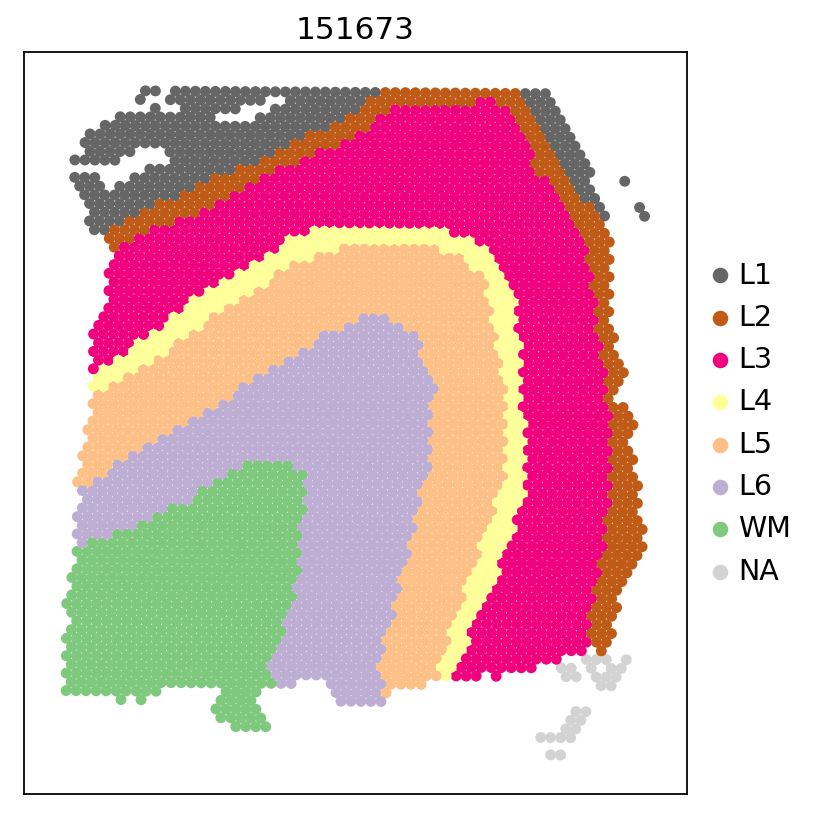

In [25]:
# plot_cell_layers(adata_spatialLIBD_151673.obs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_d[SAMPLE_ID_N],
    img_key=None,
    color="spatialLIBD",
    palette="Accent_r",
    size=1.5,
    title=SAMPLE_ID_N,
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax,
)

ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")

fig.show()


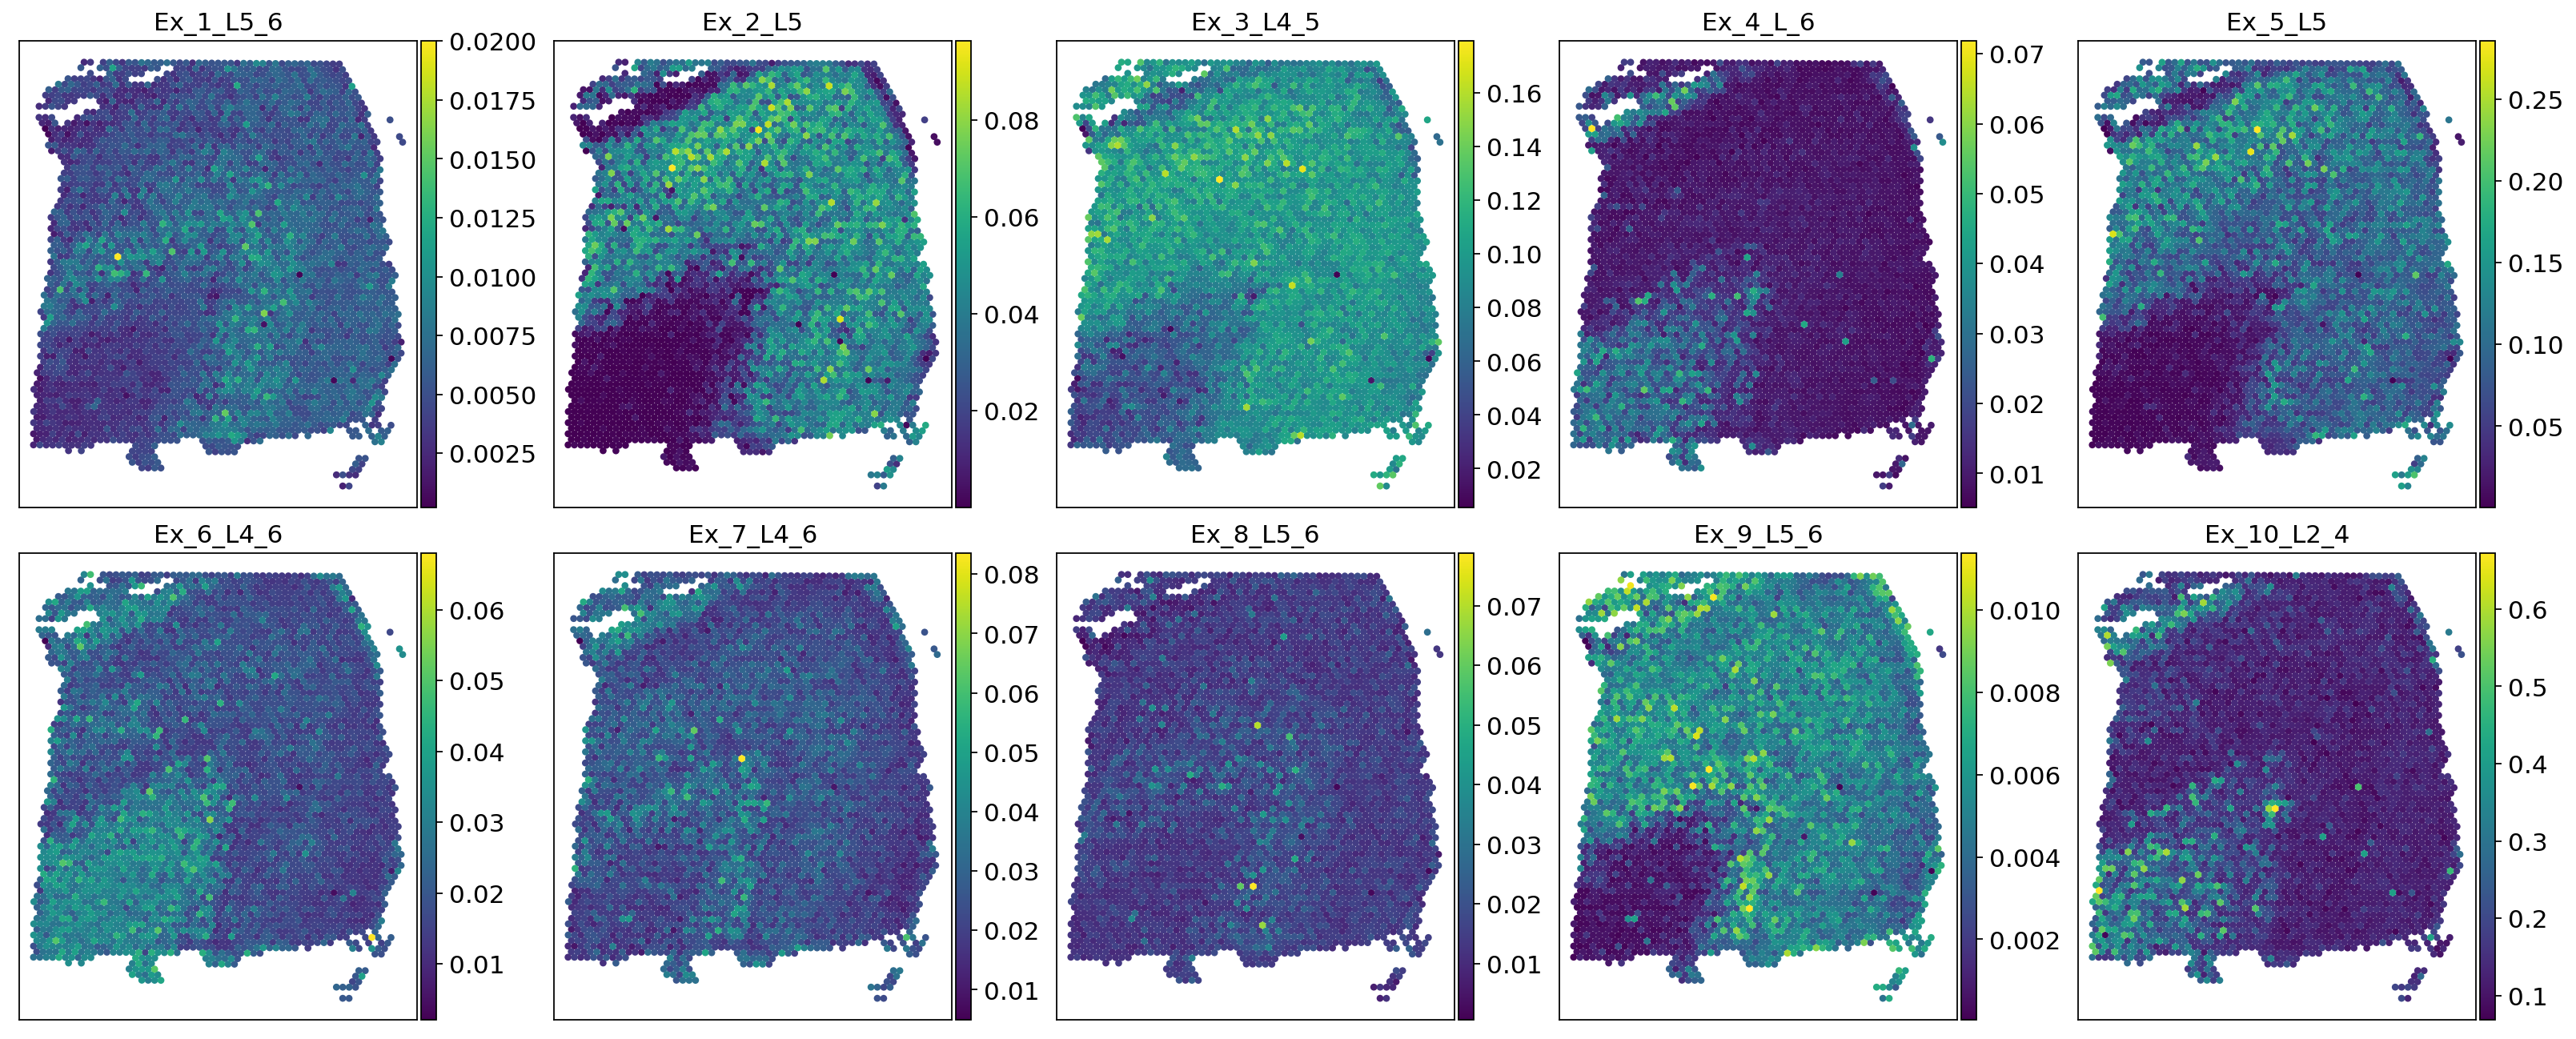

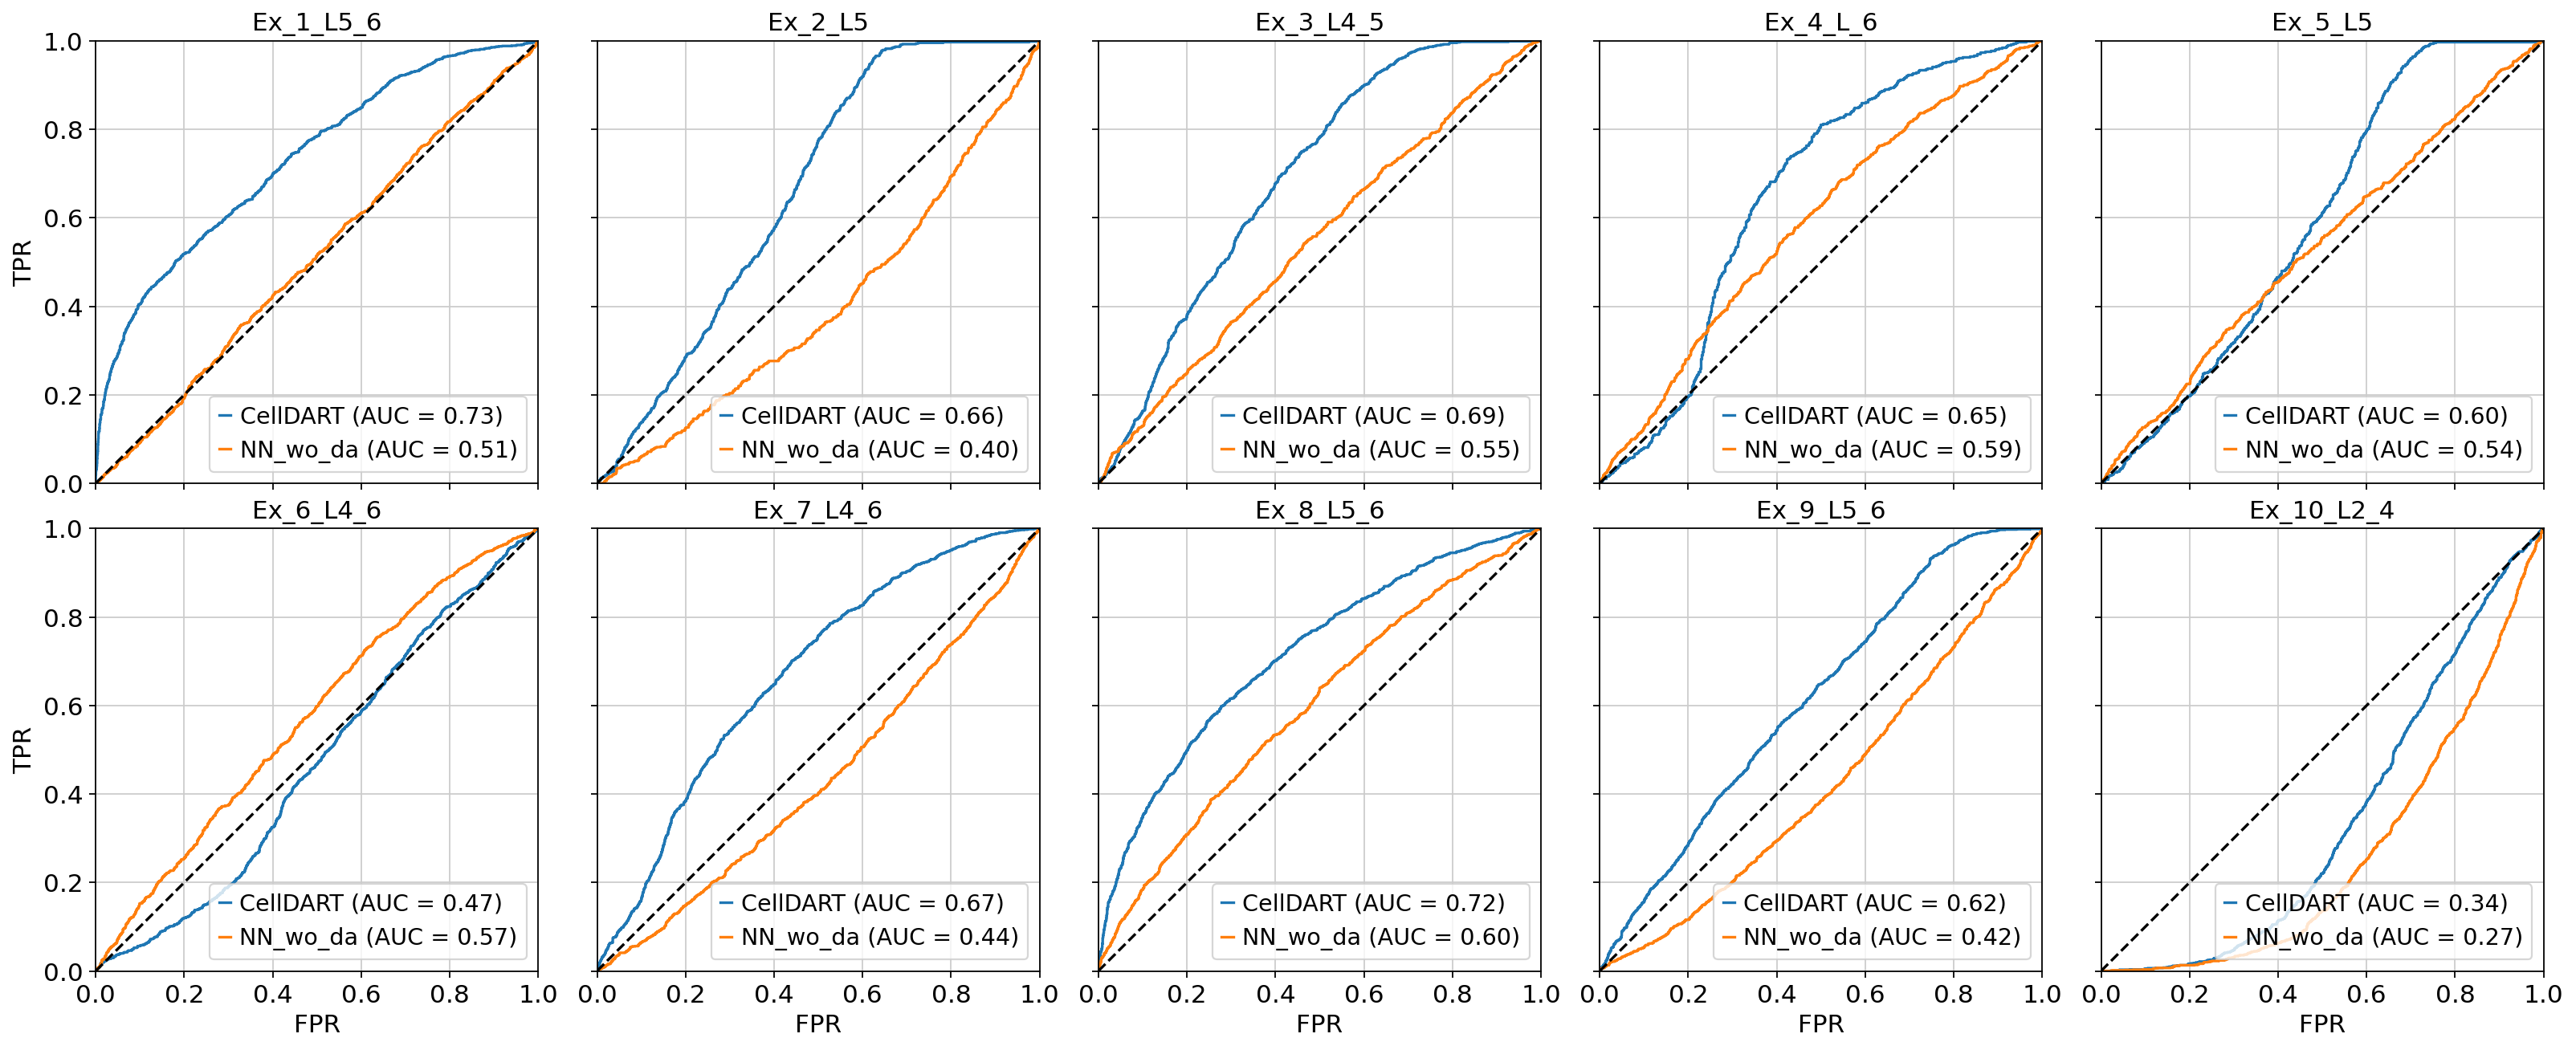

In [26]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(
        num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
    )
    ax.flat[i].axis("equal")
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")

fig.show()
# plt.close()

fig, ax = plt.subplots(
    2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
)

for i, num in enumerate(numlist):
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_d[SAMPLE_ID_N],
        "CellDART",
        ax.flat[i],
    )
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_noda_d[SAMPLE_ID_N],
        "NN_wo_da",
        ax.flat[i],
    )
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    ax.flat[i].set_title(f"{sc_sub_dict[num]}")

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel("FPR")
    else:
        ax.flat[i].set_xlabel("")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("TPR")
    else:
        ax.flat[i].set_ylabel("")

fig.show()
# plt.close()


- cf. Prediction of Mixture (pseudospots)


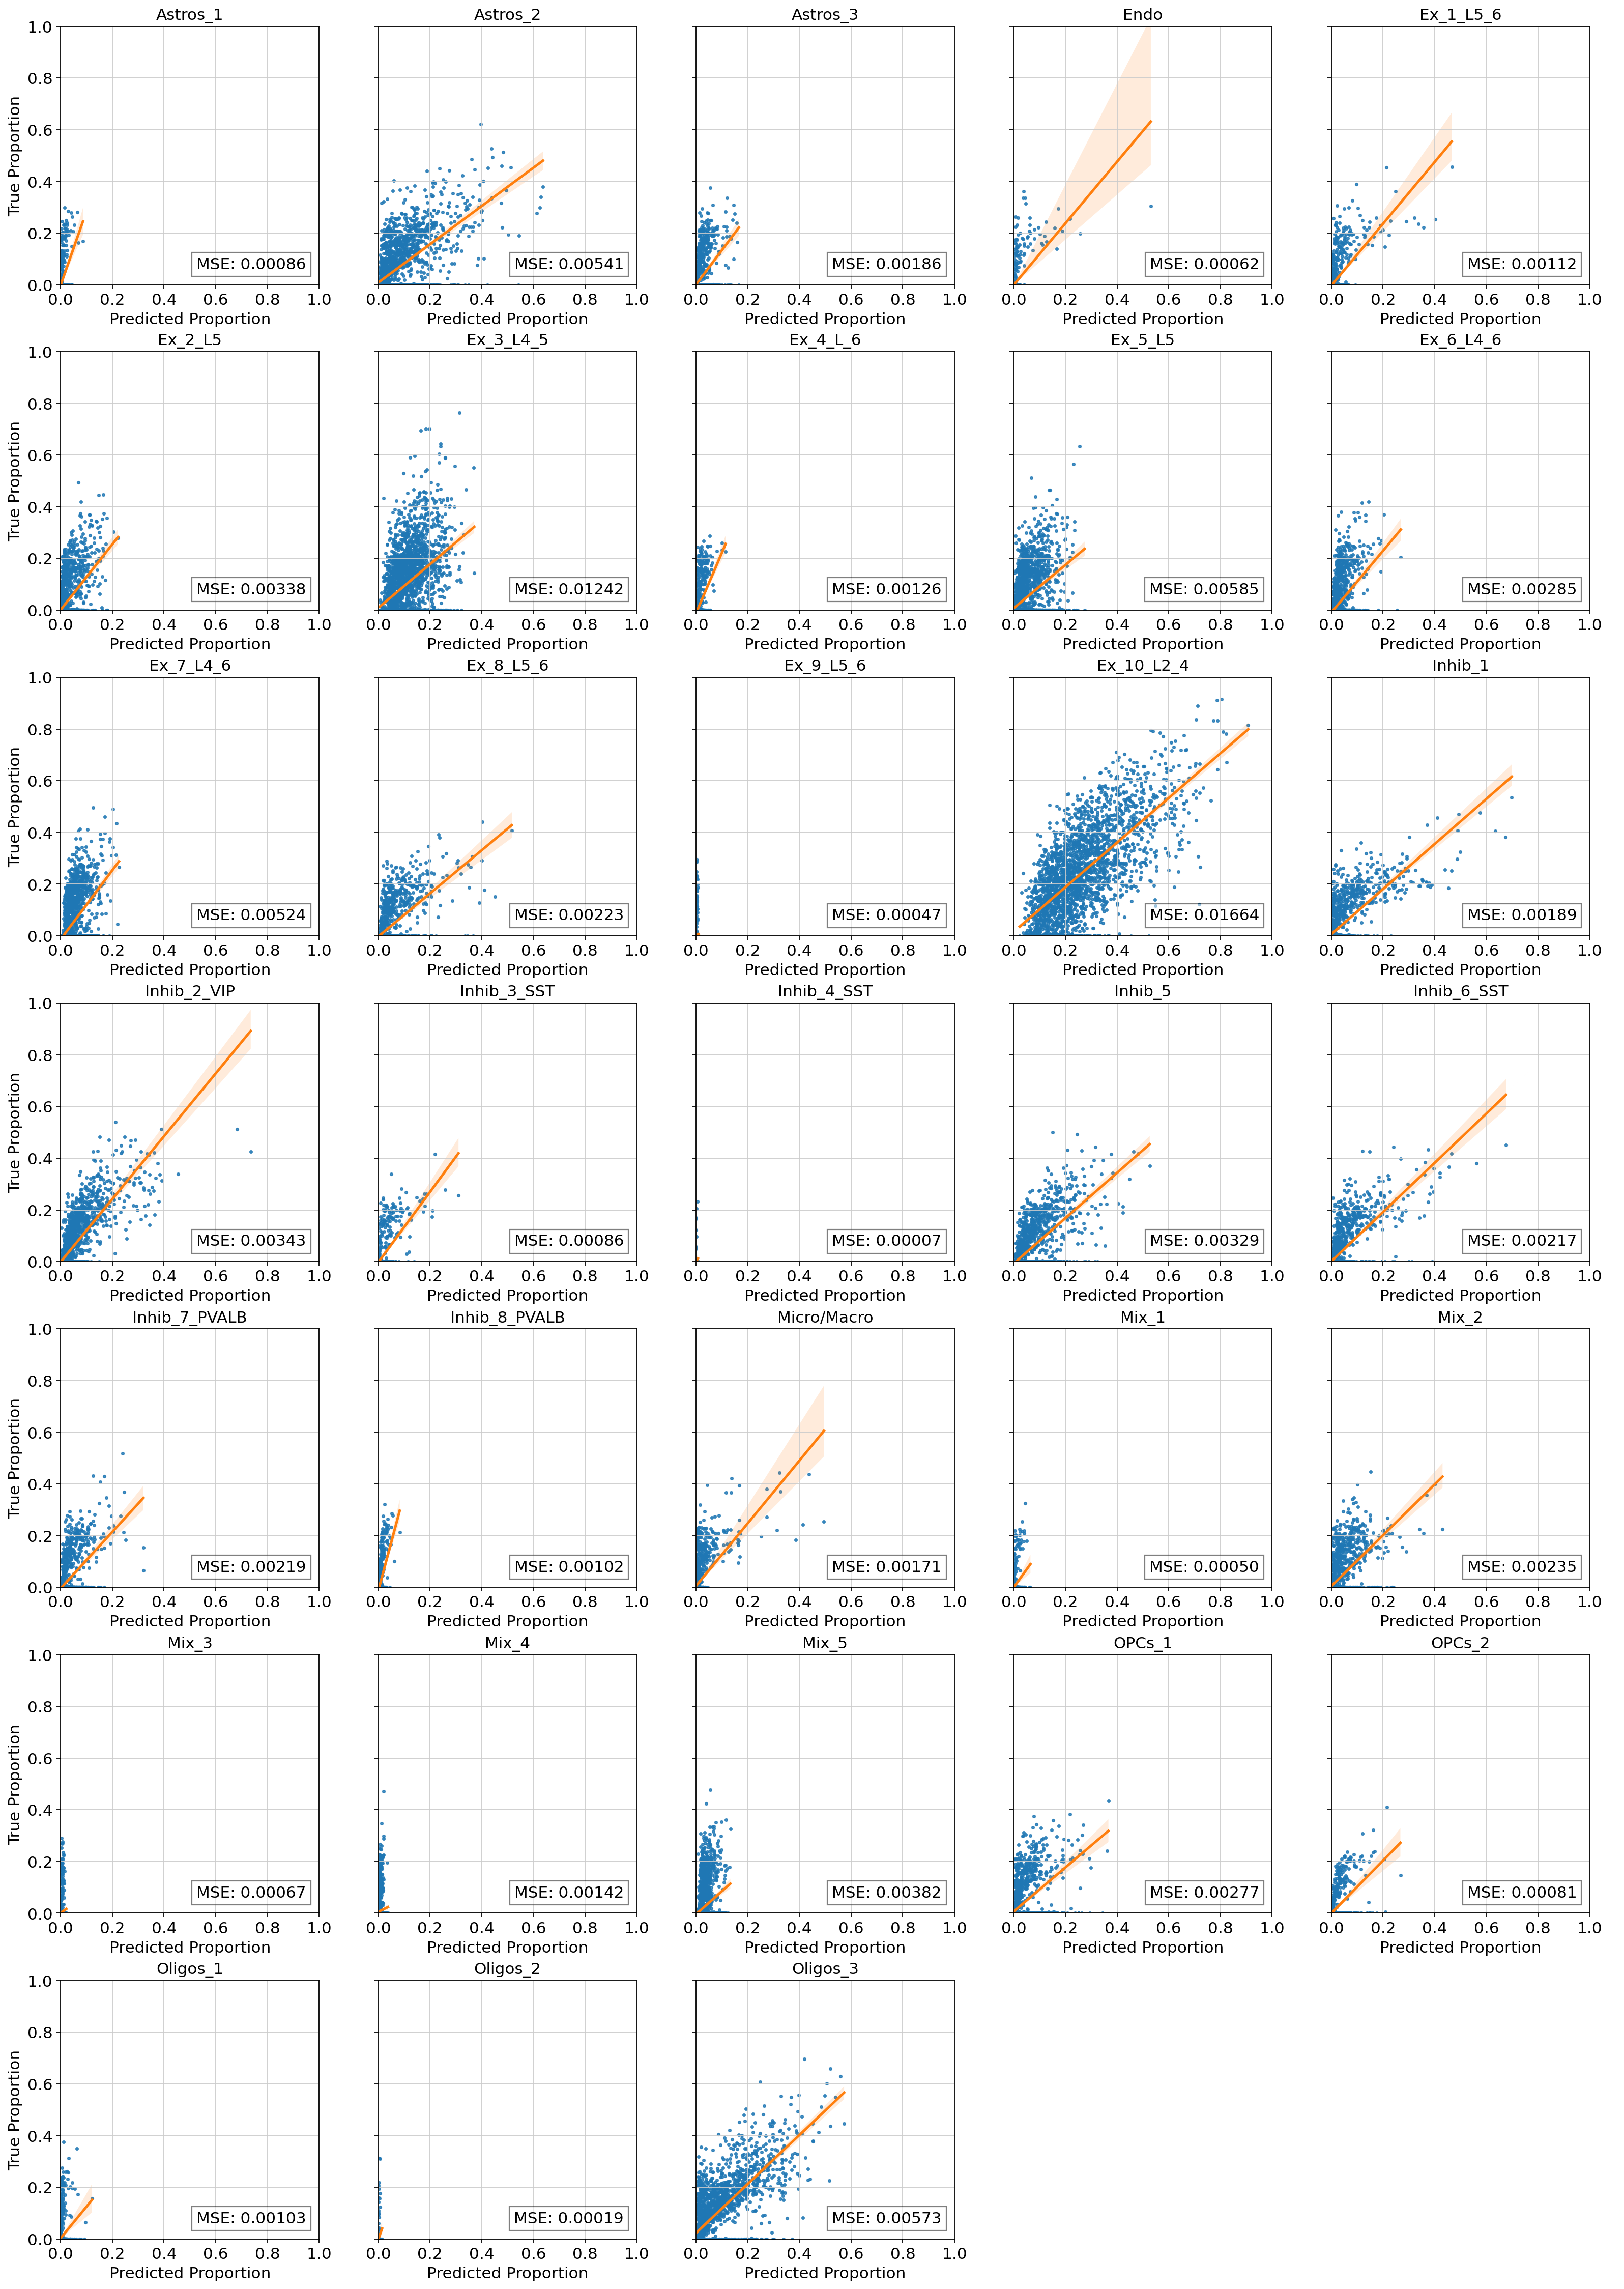

In [27]:
if TRAIN_USING_ALL_ST_SAMPLES:
    pred_mix = clssmodel.predict(sc_mix_test_s)
else:
    pred_mix = clssmodel_d[SAMPLE_ID_N].predict(sc_mix_test_s)


cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {"color": "tab:orange"}
scatter_kws = {"s": 5}

props = dict(facecolor="w", alpha=0.5)

fig, ax = plt.subplots(
    nrows,
    5,
    figsize=(20, 4 * nrows),
    constrained_layout=True,
    sharex=False,
    sharey=True,
)
for i, num in enumerate(cell_type_nums):
    sns.regplot(
        x=pred_mix[:, num],
        y=lab_mix_test[:, num],
        line_kws=line_kws,
        scatter_kws=scatter_kws,
        ax=ax.flat[i],
    ).set_title(sc_sub_dict[num])
    ax.flat[i].set_aspect("equal")

    ax.flat[i].set_xlabel("Predicted Proportion")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("True Proportion")
    else:
        ax.flat[i].set_ylabel("")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    textstr = f"MSE: {mean_squared_error(pred_mix[:,num], lab_mix_test[:,num]):.5f}"

    # place a text box in upper left in axes coords
    ax.flat[i].text(
        0.95,
        0.05,
        textstr,
        transform=ax.flat[i].transAxes,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
    )

for i in range(len(cell_type_nums), nrows * 5):
    ax.flat[i].axis("off")

plt.show()


In [28]:
print(
    "\n".join(
        f"{m.__name__} {m.__version__}"
        for m in globals().values()
        if getattr(m, "__version__", None)
    )
)


anndata 0.8.0
h5py 3.7.0
numpy 1.20.3
pandas 1.4.3
scanpy 1.9.1
seaborn 0.11.2
